# 2. Run the dimensionality reduction methods!

In [12]:
import numpy as np
import os
PREFIX = os.path.join(os.environ["HOME"], "plink-182")
DATA_PREFIX = os.path.join(PREFIX, "data")
OUT_PREFIX = os.path.join(PREFIX, "dr_outputs")

# The number of PCs to generate for PCA and PCoA (rather than computing all of them, which
# is computationally expensive and not really necessary here). 20 is the default that plink uses:
# see https://www.cog-genomics.org/plink/1.9/strat#pca.
NUM_PCS = 20

## Define "method + hyperparameter combinations" to test

`method2hpsettings` is a dictionary that maps the dimensionality reduction method name to a list of dictionaries defining the hyperparameter settings to try for that method. The total number of dictionaries within lists defines the number of different "method + hyperparameter combinations" to test.

In [21]:
import itertools

method2hpsettings = {
    "PCA": [{"whiten": False}, {"whiten": True}],
    "PCoA": [
        {"metric": "jaccard"},
        {"metric": "braycurtis"},
        {"metric": "canberra"},
        {"metric": "manhattan"},
        {"metric": "hamming"}
    ],
    "t-SNE": [],
    "UMAP": []
}


def add_cartesian_product_of_param_lists(method, param_names, *param_lists):
    """Adds "all combinations" of specified hyperparameter settings for a method to method2hpsettings.

       This is done using itertools.product(), which computes the Cartesian product of a collection
       of lists.

    Parameters
    ----------
        method: str
            A method name. This should be a key in method2hpsettings.
            
        param_names: ordered collection (list, tuple, etc.)
            A collection of hyperparameter names. The length of this collection should be equal to the
            number of lists passed to param_lists.
            
        param_lists: at least two lists
            An arbitrarily large (but at minimum two) amount of lists specifying all values to test
            for a given hyperparameter.
            
    Example
    -------
        >>> add_cartesian_product_of_param_lists("asdf", ["a", "b"], [0,1,2], [3,4,5])

        After doing this, method2hpsettings["asdf"] will be set to
            [{'a': 0, 'b': 3}, {'a': 0, 'b': 4}, {'a': 0, 'b': 5},
             {'a': 1, 'b': 3}, {'a': 1, 'b': 4}, {'a': 1, 'b': 5},
             {'a': 2, 'b': 3}, {'a': 2, 'b': 4}, {'a': 2, 'b': 5}].
             
    References
    ----------
    Thanks to https://stackoverflow.com/a/12935562/10730311 for pointing me to itertools.product().
    """
    method2hpsettings[method] = []
    combos = itertools.product(*param_lists)
    for c in combos:
        settings = {}
        i = 0
        for p in param_names:
            settings[p] = c[i]
            i += 1
        method2hpsettings[method].append(settings)
        
# Add t-SNE hyperparameter settings automatically
perplexities_to_test = [2, 3, 10, 20, 30, 50, 100, 500, 1000, 2500]
metrics_to_test = ["jaccard", "braycurtis", "canberra", "manhattan", "hamming"]
add_cartesian_product_of_param_lists("t-SNE", ["perplexity", "metric"], perplexities_to_test, metrics_to_test)

# Add UMAP hyperparameter settings similarly
# We're just testing the "major parameters" described at
# https://umap-learn.readthedocs.io/en/latest/parameters.html (except n_components, which is always 2)
n_neighbors_to_test = [2, 3, 10, 15, 30, 50, 100, 200, 1000]
min_dist_to_test = [0, 0.1, 0.25, 0.5]
add_cartesian_product_of_param_lists(
    "UMAP",
    ["n_neighbors", "min_dist", "metric"],
    n_neighbors_to_test,
    min_dist_to_test,
    metrics_to_test
)

def hp_settings_to_string(hp_settings):
    """Converts a dictionary representing hyperparameter settings to a string.
    
       Useful for generating unique filenames for dimensionality reduction results.
       
       >>> hp_settings_to_string({"metric": "jaccard", "thing2": "asdf"})
       "HPS_metric_jaccard_thing2_asdf"
    """
    out = "HPS"
    # Sort keys (hyperparameter names) in alphabetical order to ensure consistency
    for hp in sorted(hp_settings.keys()):
        out += "_{}_{}".format(hp, hp_settings[hp])
    return out


def get_filename(dr_type, hp_settings):
    """Given a dimensionality reduction type and a dict of hyperparameter settings, produces
       a unique filename for the sample coordinates produced from running this D.R. method + hyperparameter
       combination.
    
       >>> get_filename("t-SNE", {"perplexity": 30, "metric": "canberra"})
       "/dsmlp/datasets/home/home-03/88/988/mfedarko/plink-182/dr_outputs/t-SNE_perplexity_30_metric_canberra.txt"
    """
    base_fn = "{}_{}.txt".format(dr_type, hp_settings_to_string(hp_settings))
    return os.path.join(OUT_PREFIX, base_fn)

## Load genotype matrix
This is adapted from my PSET 2 part 1 solution.

In [14]:
genotypematrix = np.loadtxt(os.path.join(DATA_PREFIX, "chr_21_genotypes.tab")).T

## PCA
This is also adapted from my PSET 2 part 1 solution.

In [8]:
from sklearn.decomposition import PCA

for pca_hp_settings in method2hpsettings["PCA"]:
    pca = PCA(n_components=NUM_PCS, **pca_hp_settings)
    # Actually run PCA on the data
    sample_coords = pca.fit_transform(genotypematrix)
    # Save the sample coordinates
    fn = get_filename("PCA", pca_hp_settings)
    np.savetxt(fn, sample_coords)

## PCoA

In [10]:
import skbio

for pcoa_hp_settings in method2hpsettings["PCoA"]:
    # we make the assumption that the only hyperparameter specified for PCoA is the distance metric
    # (of course, there are other hyperparameters we could specify in practice; this is just a simplification)
    metric = pcoa_hp_settings["metric"]
    dist_matrix = skbio.diversity.beta_diversity(metric, genotypematrix)
    pcoa_results = skbio.stats.ordination.pcoa(dist_matrix, method="fsvd", number_of_dimensions=NUM_PCS)
    fn = get_filename("PCoA", pcoa_hp_settings)
    pcoa_results.samples.to_csv(fn, sep="\t", header=False, index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


## "Initial" PCA run before t-SNE and UMAP

A common recommendation with t-SNE is to first run PCA on the data (reducing it to ~50 dimensions), *then* run t-SNE on that reduced data. This is recommended, for example, in [scikit-learn's documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE.fit_transform).

This also seems to be a common practice for UMAP, as discussed in the context of single-cell RNAseq data [here](https://www.biostars.org/p/392646/). From [UMAP's paper](https://arxiv.org/pdf/1802.03426.pdf), it seems to perform adequately with larger datasets than t-SNE, however.

For the sake of simplicity and consistency, we run PCA once here (reducing the dataset to 50 dimensions, as recommended by scikit-learn) and use this reduced dataset as the input for all t-SNE and UMAP runs here. This is clearly a limitation -- this initial reduction could be argued to itself be a sort of "hyperparameter" for these algorithms.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
reduced_dataset = pca.fit_transform(genotypematrix)
np.savetxt(os.path.join(OUT_PREFIX, "Initial_PCA_run_50dims.txt"), reduced_dataset)

## t-SNE

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reduced_dataset = np.loadtxt(os.path.join(OUT_PREFIX, "Initial_PCA_run_50dims.txt"))

i = 1
num_tsne_runs = len(method2hpsettings["t-SNE"])
# Run t-SNE
for tsne_hp_settings in method2hpsettings["t-SNE"]:
    print("Running t-SNE with MHC combo #{} / {}: {}".format(i, num_tsne_runs, tsne_hp_settings))
    tsne = TSNE(n_components=2, **tsne_hp_settings)
    sample_coords = tsne.fit_transform(reduced_dataset)
    fn = get_filename("t-SNE", tsne_hp_settings)
    np.savetxt(fn, sample_coords)
    i += 1

Running PCA as a preprocessing step...
Done with PCA preprocessing.
Running t-SNE with MHC combo #1 / 50: {'perplexity': 2, 'metric': 'jaccard'}
Running t-SNE with MHC combo #2 / 50: {'perplexity': 2, 'metric': 'braycurtis'}
Running t-SNE with MHC combo #3 / 50: {'perplexity': 2, 'metric': 'canberra'}
Running t-SNE with MHC combo #4 / 50: {'perplexity': 2, 'metric': 'manhattan'}
Running t-SNE with MHC combo #5 / 50: {'perplexity': 2, 'metric': 'hamming'}
Running t-SNE with MHC combo #6 / 50: {'perplexity': 3, 'metric': 'jaccard'}
Running t-SNE with MHC combo #7 / 50: {'perplexity': 3, 'metric': 'braycurtis'}
Running t-SNE with MHC combo #8 / 50: {'perplexity': 3, 'metric': 'canberra'}
Running t-SNE with MHC combo #9 / 50: {'perplexity': 3, 'metric': 'manhattan'}
Running t-SNE with MHC combo #10 / 50: {'perplexity': 3, 'metric': 'hamming'}
Running t-SNE with MHC combo #11 / 50: {'perplexity': 10, 'metric': 'jaccard'}
Running t-SNE with MHC combo #12 / 50: {'perplexity': 10, 'metric': 'b

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Running t-SNE with MHC combo #37 / 50: {'perplexity': 500, 'metric': 'braycurtis'}
Running t-SNE with MHC combo #38 / 50: {'perplexity': 500, 'metric': 'canberra'}
Running t-SNE with MHC combo #39 / 50: {'perplexity': 500, 'metric': 'manhattan'}
Running t-SNE with MHC combo #40 / 50: {'perplexity': 500, 'metric': 'hamming'}
Running t-SNE with MHC combo #41 / 50: {'perplexity': 1000, 'metric': 'jaccard'}


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Running t-SNE with MHC combo #42 / 50: {'perplexity': 1000, 'metric': 'braycurtis'}
Running t-SNE with MHC combo #43 / 50: {'perplexity': 1000, 'metric': 'canberra'}
Running t-SNE with MHC combo #44 / 50: {'perplexity': 1000, 'metric': 'manhattan'}
Running t-SNE with MHC combo #45 / 50: {'perplexity': 1000, 'metric': 'hamming'}
Running t-SNE with MHC combo #46 / 50: {'perplexity': 2500, 'metric': 'jaccard'}


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Running t-SNE with MHC combo #47 / 50: {'perplexity': 2500, 'metric': 'braycurtis'}
Running t-SNE with MHC combo #48 / 50: {'perplexity': 2500, 'metric': 'canberra'}
Running t-SNE with MHC combo #49 / 50: {'perplexity': 2500, 'metric': 'manhattan'}
Running t-SNE with MHC combo #50 / 50: {'perplexity': 2500, 'metric': 'hamming'}


## UMAP

In [24]:
import umap

reduced_dataset = np.loadtxt(os.path.join(OUT_PREFIX, "Initial_PCA_run_50dims.txt"))

i = 1
num_umap_runs = len(method2hpsettings["UMAP"])
for umap_hp_settings in method2hpsettings["UMAP"]:
    print("Running UMAP with MHC combo #{} / {}: {}".format(i, num_umap_runs, umap_hp_settings))
    umap_runner = umap.UMAP(n_components=2, **umap_hp_settings)
    sample_coords = umap_runner.fit_transform(reduced_dataset)
    fn = get_filename("UMAP", umap_hp_settings)
    np.savetxt(fn, sample_coords)
    i += 1

Running UMAP with MHC combo #1 / 180: {'n_neighbors': 2, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #3 / 180: {'n_neighbors': 2, 'min_dist': 0, 'metric': 'canberra'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running UMAP with MHC combo #4 / 180: {'n_neighbors': 2, 'min_dist': 0, 'metric': 'manhattan'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running UMAP with MHC combo #5 / 180: {'n_neighbors': 2, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #6 / 180: {'n_neighbors': 2, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #7 / 180: {'n_neighbors': 2, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #8 / 180: {'n_neighbors': 2, 'min_dist': 0.1, 'metric': 'canberra'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running UMAP with MHC combo #9 / 180: {'n_neighbors': 2, 'min_dist': 0.1, 'metric': 'manhattan'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Running UMAP with MHC combo #10 / 180: {'n_neighbors': 2, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #11 / 180: {'n_neighbors': 2, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #12 / 180: {'n_neighbors': 2, 'min_dist': 0.25, 'metric': 'braycurtis'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Running UMAP with MHC combo #13 / 180: {'n_neighbors': 2, 'min_dist': 0.25, 'metric': 'canberra'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running UMAP with MHC combo #14 / 180: {'n_neighbors': 2, 'min_dist': 0.25, 'metric': 'manhattan'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Running UMAP with MHC combo #15 / 180: {'n_neighbors': 2, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #16 / 180: {'n_neighbors': 2, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #17 / 180: {'n_neighbors': 2, 'min_dist': 0.5, 'metric': 'braycurtis'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Running UMAP with MHC combo #18 / 180: {'n_neighbors': 2, 'min_dist': 0.5, 'metric': 'canberra'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running UMAP with MHC combo #19 / 180: {'n_neighbors': 2, 'min_dist': 0.5, 'metric': 'manhattan'}


/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/mfedarko/.local/lib/python3.6/site-packages/umap/spectral.py:228: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


Running UMAP with MHC combo #20 / 180: {'n_neighbors': 2, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #21 / 180: {'n_neighbors': 3, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #22 / 180: {'n_neighbors': 3, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #23 / 180: {'n_neighbors': 3, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #24 / 180: {'n_neighbors': 3, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #25 / 180: {'n_neighbors': 3, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #26 / 180: {'n_neighbors': 3, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #27 / 180: {'n_neighbors': 3, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #28 / 180: {'n_neighbors': 3, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #29 / 180: {'n_neighbors': 3, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #30 / 180: {'n_neighbors': 3, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #31 / 180: {'n_neighbors': 3, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #32 / 180: {'n_neighbors': 3, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #33 / 180: {'n_neighbors': 3, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #34 / 180: {'n_neighbors': 3, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #35 / 180: {'n_neighbors': 3, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #36 / 180: {'n_neighbors': 3, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #37 / 180: {'n_neighbors': 3, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #38 / 180: {'n_neighbors': 3, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #39 / 180: {'n_neighbors': 3, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #40 / 180: {'n_neighbors': 3, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #41 / 180: {'n_neighbors': 10, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #42 / 180: {'n_neighbors': 10, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #43 / 180: {'n_neighbors': 10, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #44 / 180: {'n_neighbors': 10, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #45 / 180: {'n_neighbors': 10, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #46 / 180: {'n_neighbors': 10, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #47 / 180: {'n_neighbors': 10, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #48 / 180: {'n_neighbors': 10, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #49 / 180: {'n_neighbors': 10, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #50 / 180: {'n_neighbors': 10, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #51 / 180: {'n_neighbors': 10, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #52 / 180: {'n_neighbors': 10, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #53 / 180: {'n_neighbors': 10, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #54 / 180: {'n_neighbors': 10, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #55 / 180: {'n_neighbors': 10, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #56 / 180: {'n_neighbors': 10, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #57 / 180: {'n_neighbors': 10, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #58 / 180: {'n_neighbors': 10, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #59 / 180: {'n_neighbors': 10, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #60 / 180: {'n_neighbors': 10, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #61 / 180: {'n_neighbors': 15, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #62 / 180: {'n_neighbors': 15, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #63 / 180: {'n_neighbors': 15, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #64 / 180: {'n_neighbors': 15, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #65 / 180: {'n_neighbors': 15, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #66 / 180: {'n_neighbors': 15, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #67 / 180: {'n_neighbors': 15, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #68 / 180: {'n_neighbors': 15, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #69 / 180: {'n_neighbors': 15, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #70 / 180: {'n_neighbors': 15, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #71 / 180: {'n_neighbors': 15, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #72 / 180: {'n_neighbors': 15, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #73 / 180: {'n_neighbors': 15, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #74 / 180: {'n_neighbors': 15, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #75 / 180: {'n_neighbors': 15, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #76 / 180: {'n_neighbors': 15, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #77 / 180: {'n_neighbors': 15, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #78 / 180: {'n_neighbors': 15, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #79 / 180: {'n_neighbors': 15, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #80 / 180: {'n_neighbors': 15, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #81 / 180: {'n_neighbors': 30, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #82 / 180: {'n_neighbors': 30, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #83 / 180: {'n_neighbors': 30, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #84 / 180: {'n_neighbors': 30, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #85 / 180: {'n_neighbors': 30, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #86 / 180: {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #87 / 180: {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #88 / 180: {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #89 / 180: {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #90 / 180: {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #91 / 180: {'n_neighbors': 30, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #92 / 180: {'n_neighbors': 30, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #93 / 180: {'n_neighbors': 30, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #94 / 180: {'n_neighbors': 30, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #95 / 180: {'n_neighbors': 30, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #96 / 180: {'n_neighbors': 30, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #97 / 180: {'n_neighbors': 30, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #98 / 180: {'n_neighbors': 30, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #99 / 180: {'n_neighbors': 30, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #100 / 180: {'n_neighbors': 30, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #101 / 180: {'n_neighbors': 50, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #102 / 180: {'n_neighbors': 50, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #103 / 180: {'n_neighbors': 50, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #104 / 180: {'n_neighbors': 50, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #105 / 180: {'n_neighbors': 50, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #106 / 180: {'n_neighbors': 50, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #107 / 180: {'n_neighbors': 50, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #108 / 180: {'n_neighbors': 50, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #109 / 180: {'n_neighbors': 50, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #110 / 180: {'n_neighbors': 50, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #111 / 180: {'n_neighbors': 50, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #112 / 180: {'n_neighbors': 50, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #113 / 180: {'n_neighbors': 50, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #114 / 180: {'n_neighbors': 50, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #115 / 180: {'n_neighbors': 50, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #116 / 180: {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #117 / 180: {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #118 / 180: {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #119 / 180: {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #120 / 180: {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #121 / 180: {'n_neighbors': 100, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #122 / 180: {'n_neighbors': 100, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #123 / 180: {'n_neighbors': 100, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #124 / 180: {'n_neighbors': 100, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #125 / 180: {'n_neighbors': 100, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #126 / 180: {'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #127 / 180: {'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #128 / 180: {'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #129 / 180: {'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #130 / 180: {'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #131 / 180: {'n_neighbors': 100, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #132 / 180: {'n_neighbors': 100, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #133 / 180: {'n_neighbors': 100, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #134 / 180: {'n_neighbors': 100, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #135 / 180: {'n_neighbors': 100, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #136 / 180: {'n_neighbors': 100, 'min_dist': 0.5, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #137 / 180: {'n_neighbors': 100, 'min_dist': 0.5, 'metric': 'braycurtis'}
Running UMAP with MHC combo #138 / 180: {'n_neighbors': 100, 'min_dist': 0.5, 'metric': 'canberra'}
Running UMAP with MHC combo #139 / 180: {'n_neighbors': 100, 'min_dist': 0.5, 'metric': 'manhattan'}
Running UMAP with MHC combo #140 / 180: {'n_neighbors': 100, 'min_dist': 0.5, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #141 / 180: {'n_neighbors': 200, 'min_dist': 0, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #142 / 180: {'n_neighbors': 200, 'min_dist': 0, 'metric': 'braycurtis'}
Running UMAP with MHC combo #143 / 180: {'n_neighbors': 200, 'min_dist': 0, 'metric': 'canberra'}
Running UMAP with MHC combo #144 / 180: {'n_neighbors': 200, 'min_dist': 0, 'metric': 'manhattan'}
Running UMAP with MHC combo #145 / 180: {'n_neighbors': 200, 'min_dist': 0, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #146 / 180: {'n_neighbors': 200, 'min_dist': 0.1, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #147 / 180: {'n_neighbors': 200, 'min_dist': 0.1, 'metric': 'braycurtis'}
Running UMAP with MHC combo #148 / 180: {'n_neighbors': 200, 'min_dist': 0.1, 'metric': 'canberra'}
Running UMAP with MHC combo #149 / 180: {'n_neighbors': 200, 'min_dist': 0.1, 'metric': 'manhattan'}
Running UMAP with MHC combo #150 / 180: {'n_neighbors': 200, 'min_dist': 0.1, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #151 / 180: {'n_neighbors': 200, 'min_dist': 0.25, 'metric': 'jaccard'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Running UMAP with MHC combo #152 / 180: {'n_neighbors': 200, 'min_dist': 0.25, 'metric': 'braycurtis'}
Running UMAP with MHC combo #153 / 180: {'n_neighbors': 200, 'min_dist': 0.25, 'metric': 'canberra'}
Running UMAP with MHC combo #154 / 180: {'n_neighbors': 200, 'min_dist': 0.25, 'metric': 'manhattan'}
Running UMAP with MHC combo #155 / 180: {'n_neighbors': 200, 'min_dist': 0.25, 'metric': 'hamming'}


/home/mfedarko/.local/lib/python3.6/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


KeyboardInterrupt: 

## Visualize first two PCs / axes for all methods

This code was mostly adapted from PS2, part 1. We streamlined the code a bit and added some logic to make the colors consistent for each of the five superpopulations present in 1000 Genomes.

In [9]:
%pylab inline
import matplotlib
    
####### Set up sample lists and color information -- this is just done once #####
# Load population labels
sample_to_pop = {}
with open("/datasets/cs284s-sp20-public/ps2/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

### Determine colors for each population group ###
# As is documented on https://piazza.com/class/k87p6hvsod51q6?cid=20, the original colors for
# this PSET were somewhat misleading. Here, we ensure that all populations within a superpopulation
# are colored identically.
# These are *roughly* the same colors as were used for this PSET (i.e. AFR samples are red, EAS samples
# are green, EUR samples are yellow, SAS samples are orange)
superpop_to_color = {
    "AFR": "red", "EAS": "green", "EUR": "yellow", "SAS": "orange", "AMR": "blue", "None": "gray"
}
pop_to_superpop = {"None": "None"}
# Derived from the population-label loading code above
with open(os.path.join(DATA_PREFIX, "pop_to_superpop.tsv"), "r") as p2sp:
    for line in p2sp:
        split_line = line.strip().split("\t")
        pop_to_superpop[split_line[0]] = split_line[2]

# Load samples list and get populations, then superpopulations, then colors
samples = [item.strip() for item in open(os.path.join(DATA_PREFIX, "sample_ids.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = superpop_to_color[pop_to_superpop[pop]]
    colors.append(color)

def visualize_sample_coords(dr_type, hp_settings):
    # Get filename for this run
    sample_coords_filepath = get_filename(dr_type, hp_settings)
    
    # Load the sample coordinates
    sample_coords = np.loadtxt(sample_coords_filepath)
    pc1 = sample_coords[:, 0]
    pc2 = sample_coords[:, 1]

    # Make a "description" of the hyperparameters, used for generating a subtitle
    hp_desc_list = []
    for hp in hp_settings:
        hp_desc_list.append("{}: {}".format(hp, hp_settings[hp]))
    hp_desc = "; ".join(hp_desc_list)
    
    # Make the plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pc1, pc2, color=colors, s=5)
    
    # Set titles and labels
    ax.set_title("{}\n{}".format(dr_type, hp_desc))
    
    # Set axis labels (for t-SNE / etc. the axes aren't really "PCs", so we just
    # call them "Axes" for the sake of everyone's sanity)
    if dr_type in ("PCA", "PCoA"):
        axis_label = "PC"
    else:
        axis_label = "Axis"
    ax.set_xlabel("{} 1".format(axis_label), size=15)
    ax.set_ylabel("{} 2".format(axis_label), size=15)
    
    # Other minor formatting tweaks (all taken from PSET 2 as mentioned above, I'm not
    # familiar enough with matplotlib's API to know how to do this ;)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    # Quick hack to limit each label to two digits' worth of precision. I tried
    # doing this using matplotlib's API more elegantly (e.g. StrMethodFormatter)
    # and that didn't work, hence this solution (taken from this Stack Overflow
    # comment: https://stackoverflow.com/a/50045907/10730311)
    
    # First, get string representations of the x-axis labels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # To quote that SO post :), "Beat them into submission and set them back again"
    ax.set_xticklabels([str(round(float(label), 2)) for label in labels])
    
    # Repeat above with the y-axis labels
    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])
    
    # Add color info for legend
    # (We do this manually, since we don't have the samples formatted in a way where it's easy to
    # pass them to matplotlib one-by-one for each superpopulation at a time)
    # This is based on this section of the matplotlib documentation:
    # https://matplotlib.org/3.2.1/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
    legend_patches = []
    for superpop in superpop_to_color.keys():
        legend_patches.append(
            matplotlib.patches.Patch(
                color=superpop_to_color[superpop], label=superpop
            )
        )

    ax.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.2, 1))

Populating the interactive namespace from numpy and matplotlib


### Visualize PCA

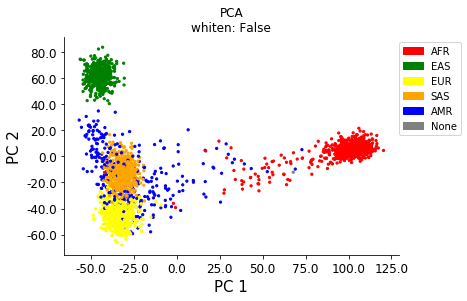

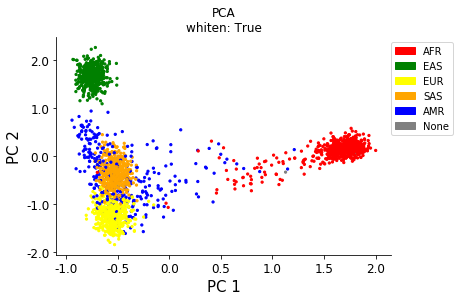

In [34]:
for hps in method2hpsettings["PCA"]:
    visualize_sample_coords("PCA", hps)

### Visualize PCoA

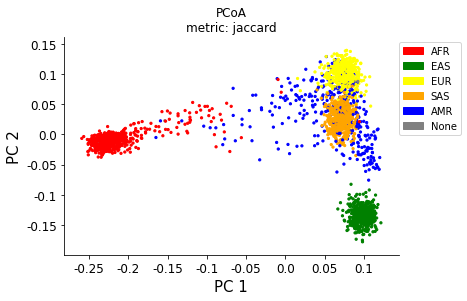

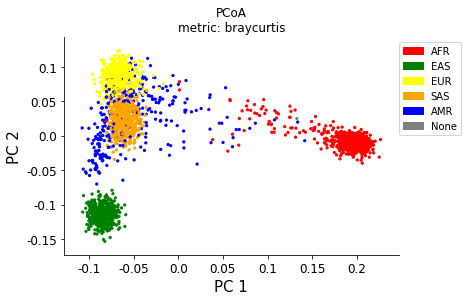

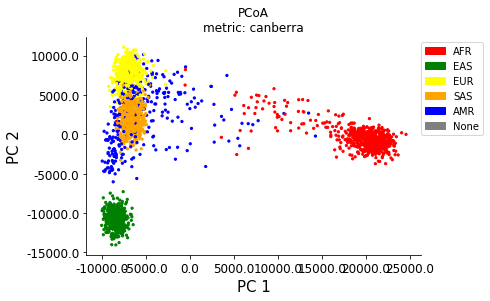

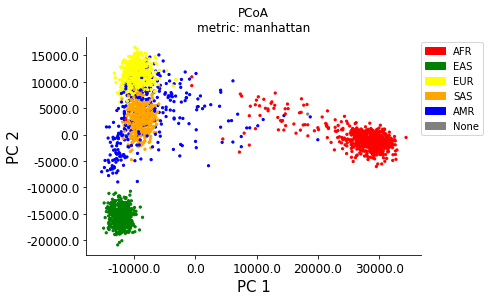

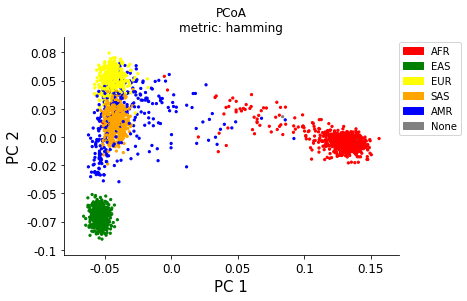

In [31]:
for hps in method2hpsettings["PCoA"]:
    visualize_sample_coords("PCoA", hps)

### Visualize t-SNE

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


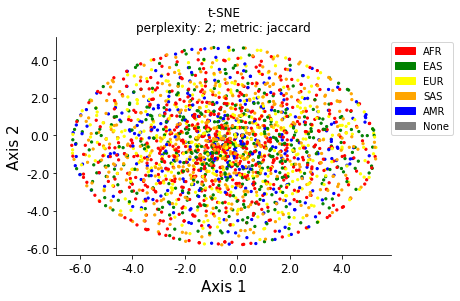

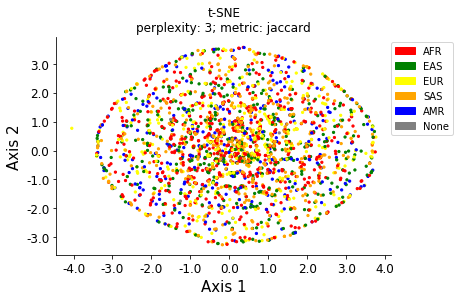

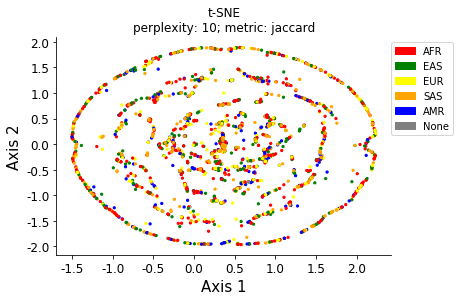

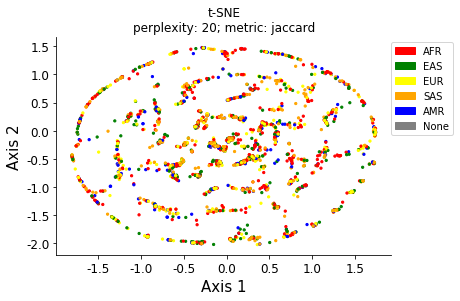

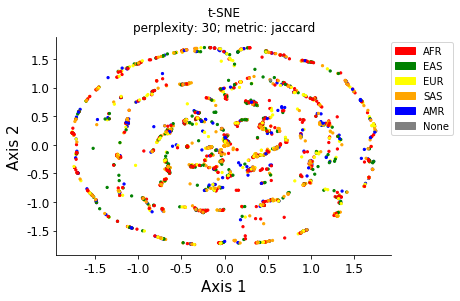

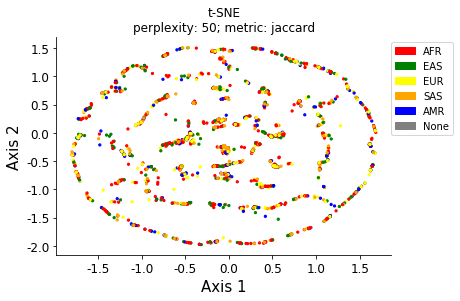

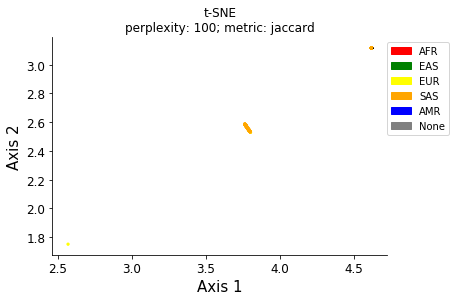

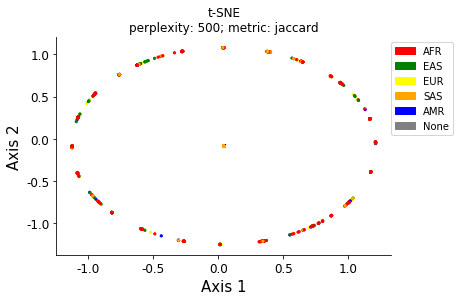

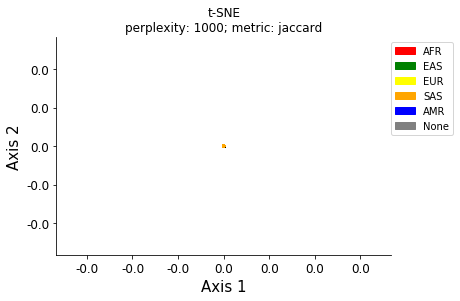

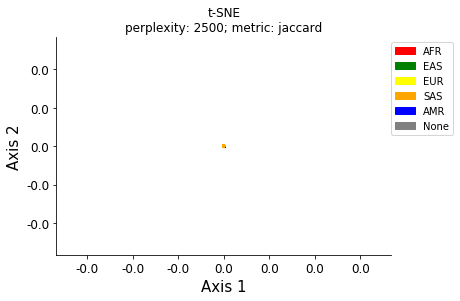

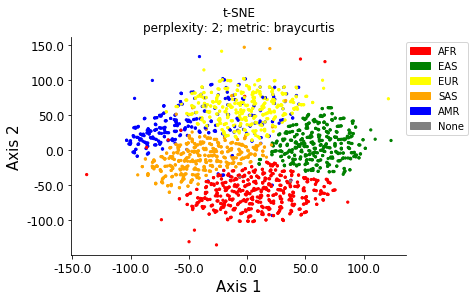

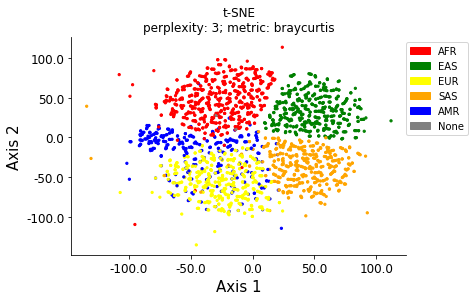

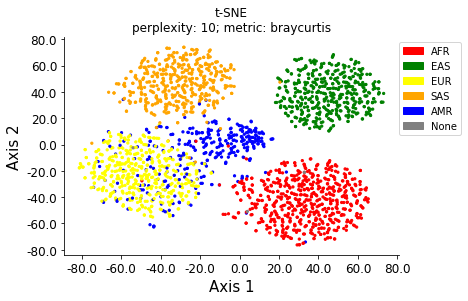

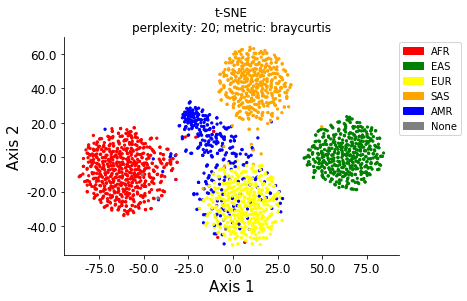

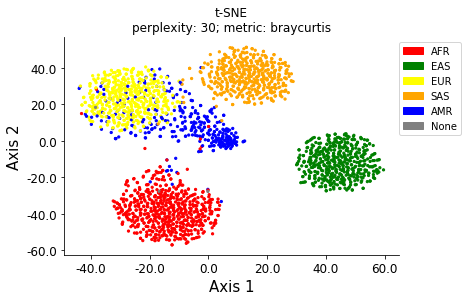

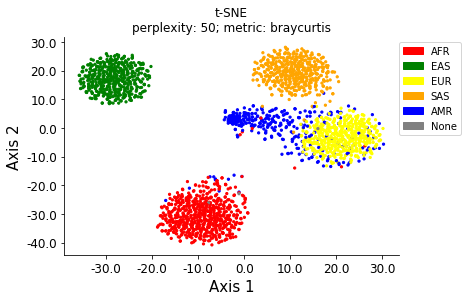

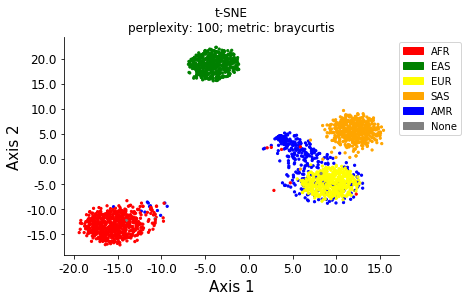

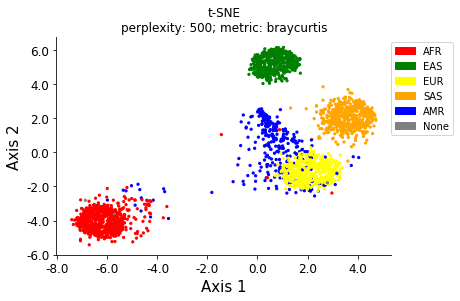

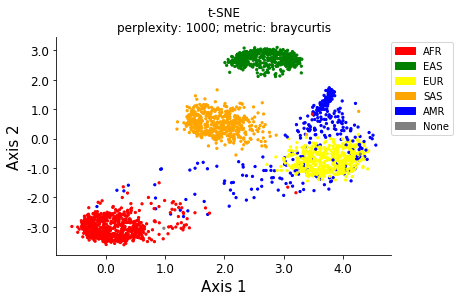

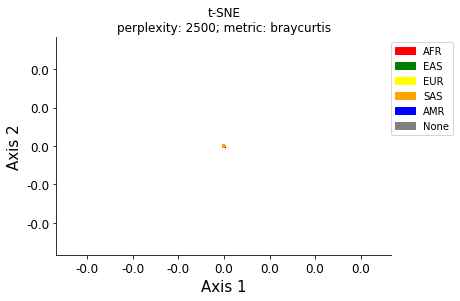

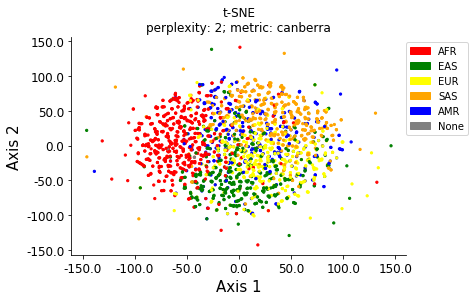

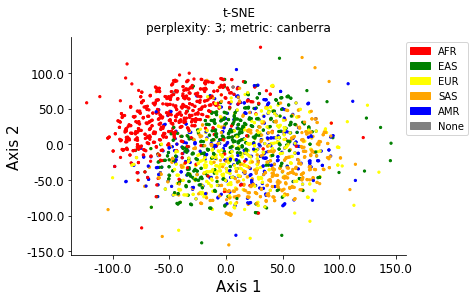

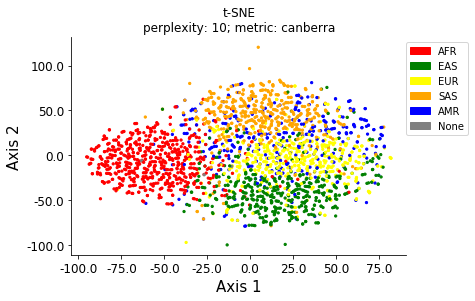

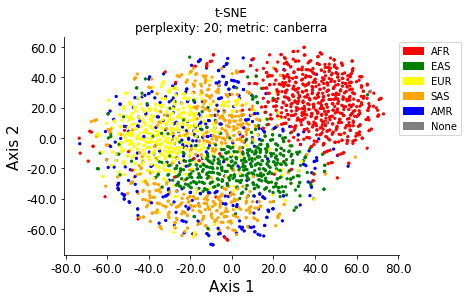

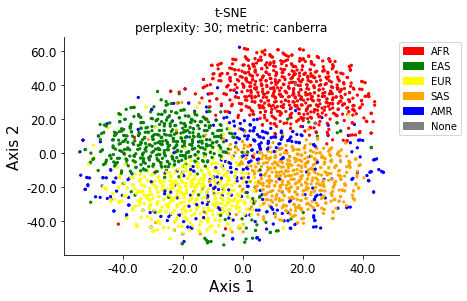

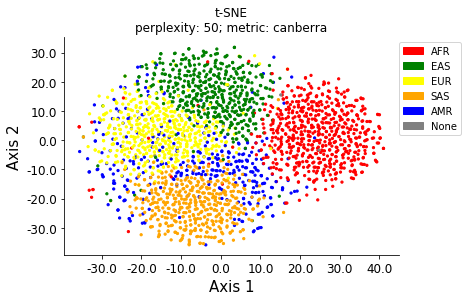

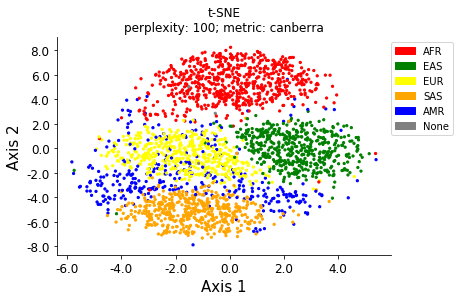

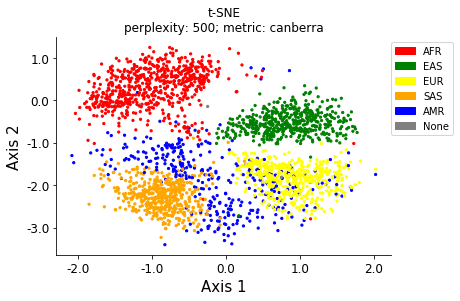

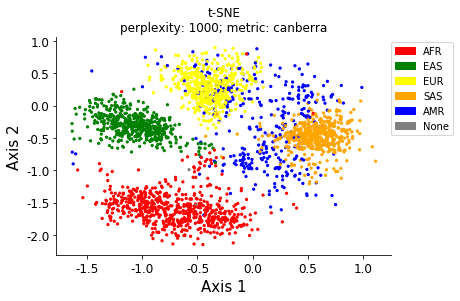

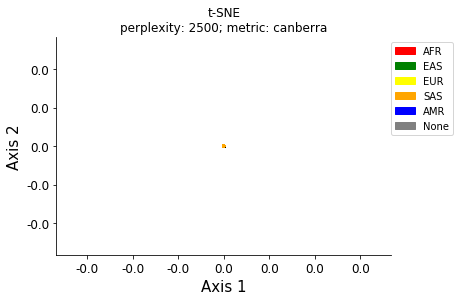

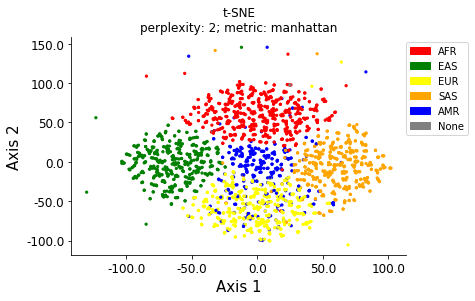

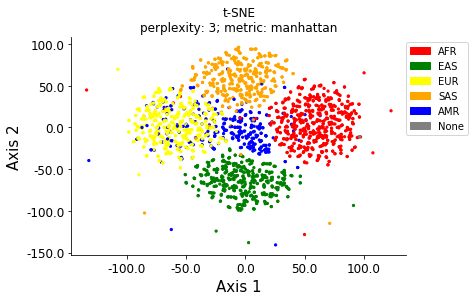

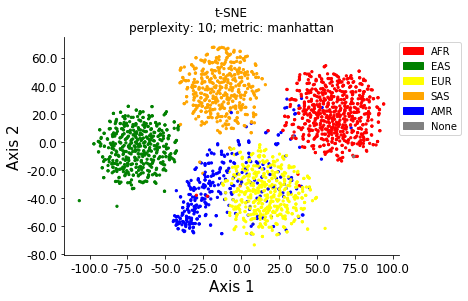

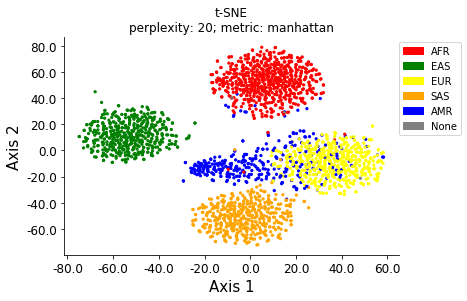

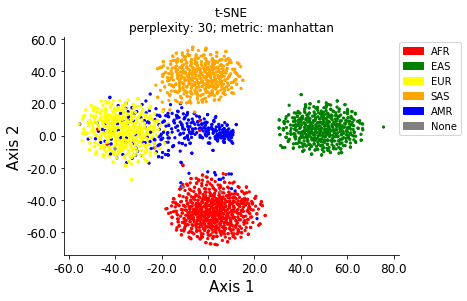

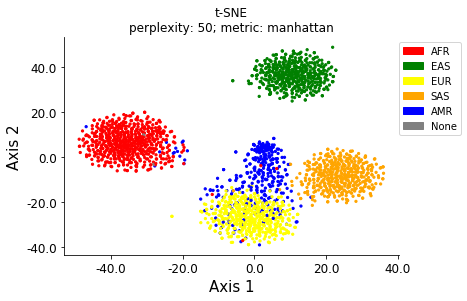

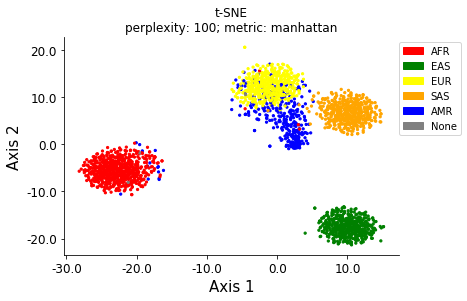

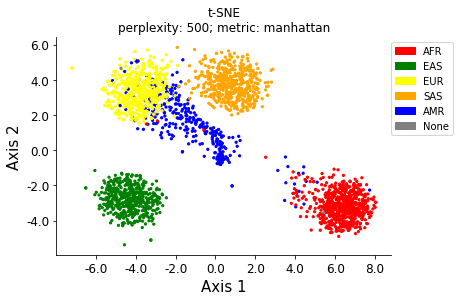

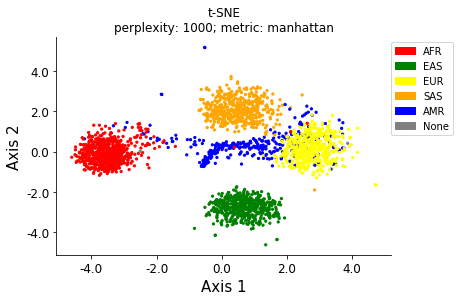

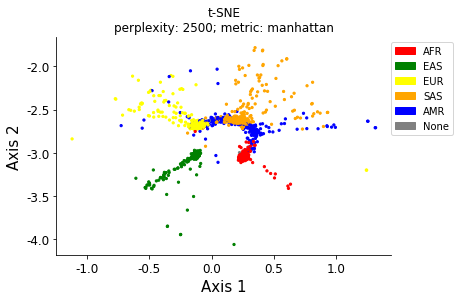

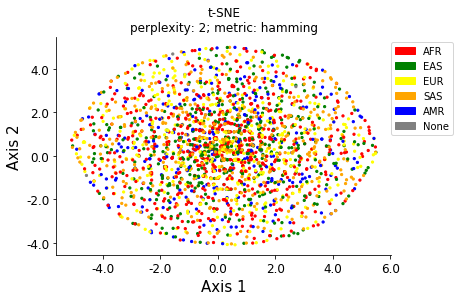

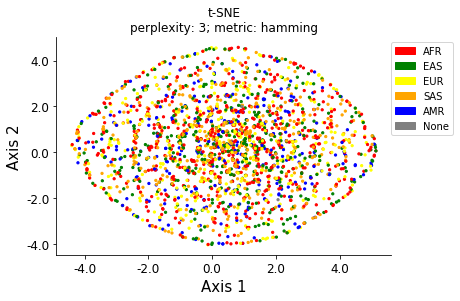

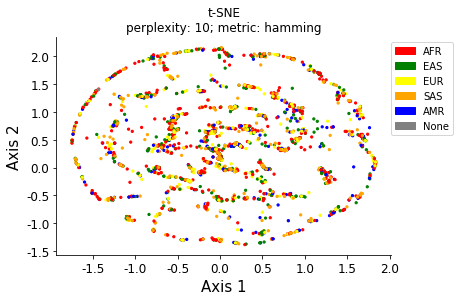

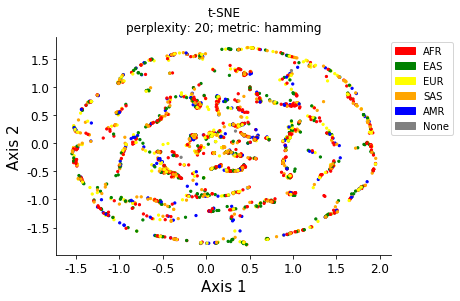

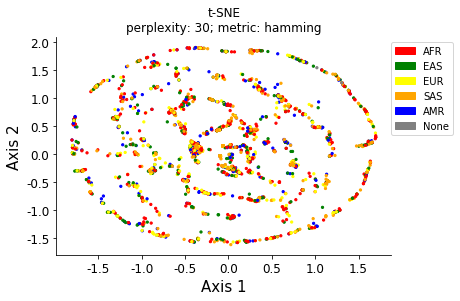

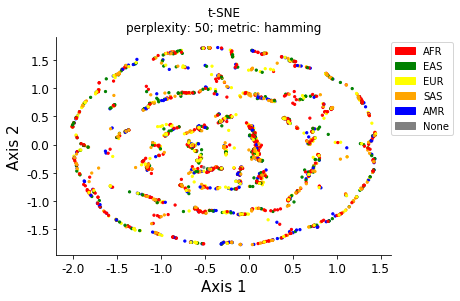

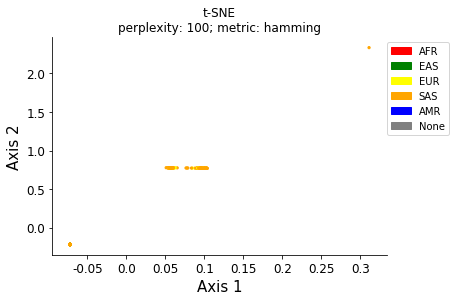

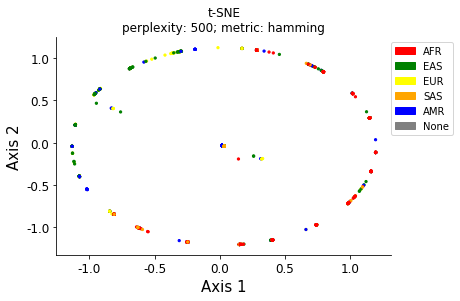

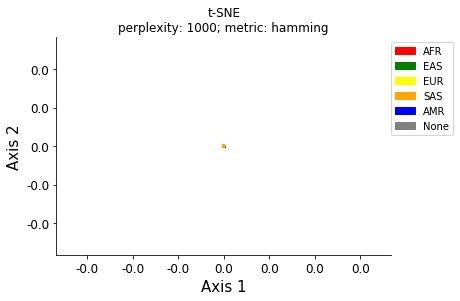

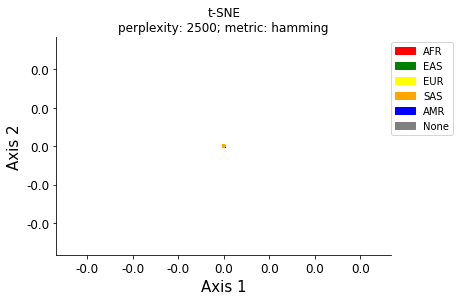

In [10]:
# Visualize all perplexities for each metric at a time (shows a more natural "progression")
for metric in metrics_to_test:
    for hps in method2hpsettings["t-SNE"]:
        if hps["metric"] == metric:
            visualize_sample_coords("t-SNE", hps)

### Visualize UMAP

In [ ]:
# Order by metric, then n_neighbors, then min_dist
for metric in metrics_to_test:
    for nn in n_neighbors_to_testghbors_to_test:
        if nn < 200:
            for md in min_dist_to_test:
                hps = {"metric": metric,, "n_neighbors": nn, "min_dist": md}
                visualize_sample_coords("UMAP", hps)